In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : True,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1457498, 828)
(1457498, 8)
validation
(253674, 828)
(253674, 8)
test
(143060, 828)
(143060, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/146 [..............................] - ETA: 3:07 - loss: 2.5070 - STD: 0.0891 - MAE: 0.2207

  4/146 [..............................] - ETA: 2s - loss: 2.2393 - STD: 0.0473 - MAE: 0.2196  

  8/146 [>.............................] - ETA: 2s - loss: 2.1711 - STD: 0.0612 - MAE: 0.2169

 12/146 [=>............................] - ETA: 2s - loss: 2.1415 - STD: 0.0608 - MAE: 0.2163

 16/146 [==>...........................] - ETA: 2s - loss: 2.1217 - STD: 0.0518 - MAE: 0.2166

 20/146 [===>..........................] - ETA: 1s - loss: 2.1103 - STD: 0.0461 - MAE: 0.2168

 24/146 [===>..........................] - ETA: 1s - loss: 2.1014 - STD: 0.0433 - MAE: 0.2169

 28/146 [====>.........................] - ETA: 1s - loss: 2.0945 - STD: 0.0423 - MAE: 0.2168

 32/146 [=====>........................] - ETA: 1s - loss: 2.0892 - STD: 0.0419 - MAE: 0.2167

 36/146 [======>.......................] - ETA: 1s - loss: 2.0848 - STD: 0.0413 - MAE: 0.2167

 40/146 [=======>......................] - ETA: 1s - loss: 2.0811 - STD: 0.0403 - MAE: 0.2167

 44/146 [========>.....................] - ETA: 1s - loss: 2.0775 - STD: 0.0392 - MAE: 0.2167

 48/146 [========>.....................] - ETA: 1s - loss: 2.0741 - STD: 0.0383 - MAE: 0.2167

 51/146 [=========>....................] - ETA: 1s - loss: 2.0710 - STD: 0.0379 - MAE: 0.2166

 55/146 [==========>...................] - ETA: 1s - loss: 2.0664 - STD: 0.0377 - MAE: 0.2165

 59/146 [===========>..................] - ETA: 1s - loss: 2.0607 - STD: 0.0376 - MAE: 0.2163

 63/146 [===========>..................] - ETA: 1s - loss: 2.0535 - STD: 0.0378 - MAE: 0.2161

 67/146 [============>.................] - ETA: 1s - loss: 2.0451 - STD: 0.0384 - MAE: 0.2158

 71/146 [=============>................] - ETA: 1s - loss: 2.0353 - STD: 0.0397 - MAE: 0.2154

 75/146 [==============>...............] - ETA: 1s - loss: 2.0239 - STD: 0.0412 - MAE: 0.2148

 79/146 [===============>..............] - ETA: 1s - loss: 2.0114 - STD: 0.0429 - MAE: 0.2142

 83/146 [================>.............] - ETA: 0s - loss: 1.9971 - STD: 0.0448 - MAE: 0.2135

 87/146 [================>.............] - ETA: 0s - loss: 1.9813 - STD: 0.0470 - MAE: 0.2127

 91/146 [=================>............] - ETA: 0s - loss: 1.9646 - STD: 0.0495 - MAE: 0.2118

 95/146 [==================>...........] - ETA: 0s - loss: 1.9475 - STD: 0.0521 - MAE: 0.2108

 99/146 [===================>..........] - ETA: 0s - loss: 1.9306 - STD: 0.0548 - MAE: 0.2098

103/146 [====================>.........] - ETA: 0s - loss: 1.9139 - STD: 0.0576 - MAE: 0.2088

107/146 [====================>.........] - ETA: 0s - loss: 1.8980 - STD: 0.0603 - MAE: 0.2078

111/146 [=====================>........] - ETA: 0s - loss: 1.8826 - STD: 0.0629 - MAE: 0.2068

115/146 [======================>.......] - ETA: 0s - loss: 1.8680 - STD: 0.0654 - MAE: 0.2059

119/146 [=======================>......] - ETA: 0s - loss: 1.8538 - STD: 0.0678 - MAE: 0.2050

123/146 [========================>.....] - ETA: 0s - loss: 1.8401 - STD: 0.0701 - MAE: 0.2041

127/146 [=========================>....] - ETA: 0s - loss: 1.8272 - STD: 0.0723 - MAE: 0.2032

131/146 [=========================>....] - ETA: 0s - loss: 1.8146 - STD: 0.0744 - MAE: 0.2024

133/146 [==========================>...] - ETA: 0s - loss: 1.8094 - STD: 0.0754 - MAE: 0.2020

137/146 [===========================>..] - ETA: 0s - loss: 1.7976 - STD: 0.0774 - MAE: 0.2012

141/146 [===========================>..] - ETA: 0s - loss: 1.7866 - STD: 0.0793 - MAE: 0.2005

145/146 [============================>.] - ETA: 0s - loss: 1.7759 - STD: 0.0812 - MAE: 0.1998

146/146 [==============================] - 5s 27ms/step - loss: 1.7733 - STD: 0.0816 - MAE: 0.1996 - val_loss: 1.6372 - val_STD: 0.1518 - val_MAE: 0.1821


Epoch 2/10000


  1/146 [..............................] - ETA: 6s - loss: 1.3820 - STD: 0.1463 - MAE: 0.1733

  5/146 [>.............................] - ETA: 2s - loss: 1.3927 - STD: 0.1470 - MAE: 0.1737

  9/146 [>.............................] - ETA: 2s - loss: 1.3855 - STD: 0.1468 - MAE: 0.1733

 13/146 [=>............................] - ETA: 2s - loss: 1.3844 - STD: 0.1469 - MAE: 0.1732

 17/146 [==>...........................] - ETA: 1s - loss: 1.3809 - STD: 0.1471 - MAE: 0.1730

 21/146 [===>..........................] - ETA: 1s - loss: 1.3774 - STD: 0.1475 - MAE: 0.1727

 24/146 [===>..........................] - ETA: 1s - loss: 1.3751 - STD: 0.1478 - MAE: 0.1725

 28/146 [====>.........................] - ETA: 1s - loss: 1.3719 - STD: 0.1481 - MAE: 0.1723

 32/146 [=====>........................] - ETA: 1s - loss: 1.3681 - STD: 0.1485 - MAE: 0.1720

 36/146 [======>.......................] - ETA: 1s - loss: 1.3647 - STD: 0.1489 - MAE: 0.1717

 40/146 [=======>......................] - ETA: 1s - loss: 1.3612 - STD: 0.1492 - MAE: 0.1714

 44/146 [========>.....................] - ETA: 1s - loss: 1.3581 - STD: 0.1496 - MAE: 0.1711

 48/146 [========>.....................] - ETA: 1s - loss: 1.3551 - STD: 0.1500 - MAE: 0.1708

 52/146 [=========>....................] - ETA: 1s - loss: 1.3519 - STD: 0.1504 - MAE: 0.1705

 56/146 [==========>...................] - ETA: 1s - loss: 1.3491 - STD: 0.1509 - MAE: 0.1702

 60/146 [===========>..................] - ETA: 1s - loss: 1.3465 - STD: 0.1514 - MAE: 0.1699

 64/146 [============>.................] - ETA: 1s - loss: 1.3432 - STD: 0.1519 - MAE: 0.1695

 68/146 [============>.................] - ETA: 1s - loss: 1.3405 - STD: 0.1524 - MAE: 0.1692

 72/146 [=============>................] - ETA: 1s - loss: 1.3375 - STD: 0.1529 - MAE: 0.1689

 76/146 [==============>...............] - ETA: 1s - loss: 1.3347 - STD: 0.1535 - MAE: 0.1685

 80/146 [===============>..............] - ETA: 1s - loss: 1.3319 - STD: 0.1539 - MAE: 0.1682

 84/146 [================>.............] - ETA: 0s - loss: 1.3290 - STD: 0.1544 - MAE: 0.1679

 88/146 [=================>............] - ETA: 0s - loss: 1.3264 - STD: 0.1549 - MAE: 0.1676

 92/146 [=================>............] - ETA: 0s - loss: 1.3235 - STD: 0.1554 - MAE: 0.1673

 96/146 [==================>...........] - ETA: 0s - loss: 1.3209 - STD: 0.1559 - MAE: 0.1670

100/146 [===================>..........] - ETA: 0s - loss: 1.3181 - STD: 0.1564 - MAE: 0.1667

104/146 [====================>.........] - ETA: 0s - loss: 1.3158 - STD: 0.1570 - MAE: 0.1664

108/146 [=====================>........] - ETA: 0s - loss: 1.3136 - STD: 0.1575 - MAE: 0.1661

112/146 [======================>.......] - ETA: 0s - loss: 1.3107 - STD: 0.1579 - MAE: 0.1658

115/146 [======================>.......] - ETA: 0s - loss: 1.3087 - STD: 0.1583 - MAE: 0.1656

119/146 [=======================>......] - ETA: 0s - loss: 1.3061 - STD: 0.1587 - MAE: 0.1653

123/146 [========================>.....] - ETA: 0s - loss: 1.3036 - STD: 0.1592 - MAE: 0.1650

127/146 [=========================>....] - ETA: 0s - loss: 1.3011 - STD: 0.1597 - MAE: 0.1647

131/146 [=========================>....] - ETA: 0s - loss: 1.2989 - STD: 0.1601 - MAE: 0.1645

135/146 [==========================>...] - ETA: 0s - loss: 1.2967 - STD: 0.1606 - MAE: 0.1642

139/146 [===========================>..] - ETA: 0s - loss: 1.2949 - STD: 0.1610 - MAE: 0.1639

143/146 [============================>.] - ETA: 0s - loss: 1.2927 - STD: 0.1614 - MAE: 0.1637

146/146 [==============================] - 3s 18ms/step - loss: 1.2911 - STD: 0.1617 - MAE: 0.1635 - val_loss: 1.5535 - val_STD: 0.1805 - val_MAE: 0.1659


Epoch 3/10000


  1/146 [..............................] - ETA: 6s - loss: 1.2115 - STD: 0.1757 - MAE: 0.1548

  5/146 [>.............................] - ETA: 2s - loss: 1.2157 - STD: 0.1758 - MAE: 0.1550

  9/146 [>.............................] - ETA: 2s - loss: 1.2147 - STD: 0.1757 - MAE: 0.1549

 13/146 [=>............................] - ETA: 1s - loss: 1.2126 - STD: 0.1758 - MAE: 0.1548

 17/146 [==>...........................] - ETA: 1s - loss: 1.2079 - STD: 0.1761 - MAE: 0.1545

 21/146 [===>..........................] - ETA: 1s - loss: 1.2050 - STD: 0.1765 - MAE: 0.1542

 24/146 [===>..........................] - ETA: 1s - loss: 1.2032 - STD: 0.1767 - MAE: 0.1541

 28/146 [====>.........................] - ETA: 1s - loss: 1.2008 - STD: 0.1770 - MAE: 0.1539

 32/146 [=====>........................] - ETA: 1s - loss: 1.1996 - STD: 0.1773 - MAE: 0.1537

 36/146 [======>.......................] - ETA: 1s - loss: 1.1989 - STD: 0.1775 - MAE: 0.1536

 40/146 [=======>......................] - ETA: 1s - loss: 1.1976 - STD: 0.1777 - MAE: 0.1534

 44/146 [========>.....................] - ETA: 1s - loss: 1.1963 - STD: 0.1780 - MAE: 0.1533

 48/146 [========>.....................] - ETA: 1s - loss: 1.1954 - STD: 0.1781 - MAE: 0.1532

 52/146 [=========>....................] - ETA: 1s - loss: 1.1941 - STD: 0.1784 - MAE: 0.1530

 56/146 [==========>...................] - ETA: 1s - loss: 1.1917 - STD: 0.1787 - MAE: 0.1528

 60/146 [===========>..................] - ETA: 1s - loss: 1.1899 - STD: 0.1789 - MAE: 0.1526

 64/146 [============>.................] - ETA: 1s - loss: 1.1884 - STD: 0.1791 - MAE: 0.1525

 68/146 [============>.................] - ETA: 1s - loss: 1.1874 - STD: 0.1794 - MAE: 0.1524

 72/146 [=============>................] - ETA: 1s - loss: 1.1861 - STD: 0.1796 - MAE: 0.1522

 76/146 [==============>...............] - ETA: 1s - loss: 1.1849 - STD: 0.1798 - MAE: 0.1521

 80/146 [===============>..............] - ETA: 1s - loss: 1.1830 - STD: 0.1800 - MAE: 0.1519

 84/146 [================>.............] - ETA: 0s - loss: 1.1813 - STD: 0.1802 - MAE: 0.1518

 88/146 [=================>............] - ETA: 0s - loss: 1.1799 - STD: 0.1804 - MAE: 0.1516

 92/146 [=================>............] - ETA: 0s - loss: 1.1785 - STD: 0.1805 - MAE: 0.1515

 96/146 [==================>...........] - ETA: 0s - loss: 1.1770 - STD: 0.1807 - MAE: 0.1514

100/146 [===================>..........] - ETA: 0s - loss: 1.1759 - STD: 0.1809 - MAE: 0.1512

104/146 [====================>.........] - ETA: 0s - loss: 1.1745 - STD: 0.1811 - MAE: 0.1511

108/146 [=====================>........] - ETA: 0s - loss: 1.1738 - STD: 0.1813 - MAE: 0.1510

111/146 [=====================>........] - ETA: 0s - loss: 1.1730 - STD: 0.1815 - MAE: 0.1509

115/146 [======================>.......] - ETA: 0s - loss: 1.1717 - STD: 0.1816 - MAE: 0.1508

119/146 [=======================>......] - ETA: 0s - loss: 1.1702 - STD: 0.1818 - MAE: 0.1506

123/146 [========================>.....] - ETA: 0s - loss: 1.1686 - STD: 0.1820 - MAE: 0.1505

127/146 [=========================>....] - ETA: 0s - loss: 1.1675 - STD: 0.1822 - MAE: 0.1503

131/146 [=========================>....] - ETA: 0s - loss: 1.1664 - STD: 0.1823 - MAE: 0.1502

135/146 [==========================>...] - ETA: 0s - loss: 1.1659 - STD: 0.1825 - MAE: 0.1501

139/146 [===========================>..] - ETA: 0s - loss: 1.1647 - STD: 0.1827 - MAE: 0.1500

143/146 [============================>.] - ETA: 0s - loss: 1.1634 - STD: 0.1828 - MAE: 0.1499

146/146 [==============================] - 3s 18ms/step - loss: 1.1627 - STD: 0.1829 - MAE: 0.1498 - val_loss: 1.4715 - val_STD: 0.1843 - val_MAE: 0.1606


Epoch 4/10000


  1/146 [..............................] - ETA: 6s - loss: 1.1218 - STD: 0.1878 - MAE: 0.1457

  5/146 [>.............................] - ETA: 2s - loss: 1.1218 - STD: 0.1886 - MAE: 0.1457

  9/146 [>.............................] - ETA: 2s - loss: 1.1197 - STD: 0.1889 - MAE: 0.1453

 13/146 [=>............................] - ETA: 2s - loss: 1.1255 - STD: 0.1893 - MAE: 0.1455

 17/146 [==>...........................] - ETA: 1s - loss: 1.1208 - STD: 0.1895 - MAE: 0.1452

 20/146 [===>..........................] - ETA: 1s - loss: 1.1185 - STD: 0.1893 - MAE: 0.1451

 24/146 [===>..........................] - ETA: 1s - loss: 1.1158 - STD: 0.1892 - MAE: 0.1450

 28/146 [====>.........................] - ETA: 1s - loss: 1.1146 - STD: 0.1894 - MAE: 0.1449

 32/146 [=====>........................] - ETA: 1s - loss: 1.1118 - STD: 0.1896 - MAE: 0.1447

 36/146 [======>.......................] - ETA: 1s - loss: 1.1109 - STD: 0.1899 - MAE: 0.1445

 40/146 [=======>......................] - ETA: 1s - loss: 1.1112 - STD: 0.1901 - MAE: 0.1444

 43/146 [=======>......................] - ETA: 1s - loss: 1.1105 - STD: 0.1902 - MAE: 0.1443

 47/146 [========>.....................] - ETA: 1s - loss: 1.1103 - STD: 0.1904 - MAE: 0.1443

 51/146 [=========>....................] - ETA: 1s - loss: 1.1094 - STD: 0.1904 - MAE: 0.1442

 55/146 [==========>...................] - ETA: 1s - loss: 1.1077 - STD: 0.1905 - MAE: 0.1441

 59/146 [===========>..................] - ETA: 1s - loss: 1.1073 - STD: 0.1906 - MAE: 0.1440

 63/146 [===========>..................] - ETA: 1s - loss: 1.1059 - STD: 0.1908 - MAE: 0.1439

 67/146 [============>.................] - ETA: 1s - loss: 1.1042 - STD: 0.1910 - MAE: 0.1437

 71/146 [=============>................] - ETA: 1s - loss: 1.1040 - STD: 0.1911 - MAE: 0.1436

 75/146 [==============>...............] - ETA: 1s - loss: 1.1025 - STD: 0.1913 - MAE: 0.1435

 79/146 [===============>..............] - ETA: 1s - loss: 1.1011 - STD: 0.1914 - MAE: 0.1433

 83/146 [================>.............] - ETA: 0s - loss: 1.1000 - STD: 0.1915 - MAE: 0.1432

 87/146 [================>.............] - ETA: 0s - loss: 1.0990 - STD: 0.1917 - MAE: 0.1431

 91/146 [=================>............] - ETA: 0s - loss: 1.0984 - STD: 0.1919 - MAE: 0.1430

 95/146 [==================>...........] - ETA: 0s - loss: 1.0972 - STD: 0.1920 - MAE: 0.1429

 99/146 [===================>..........] - ETA: 0s - loss: 1.0958 - STD: 0.1921 - MAE: 0.1427

103/146 [====================>.........] - ETA: 0s - loss: 1.0950 - STD: 0.1923 - MAE: 0.1426

107/146 [====================>.........] - ETA: 0s - loss: 1.0941 - STD: 0.1924 - MAE: 0.1425

111/146 [=====================>........] - ETA: 0s - loss: 1.0928 - STD: 0.1925 - MAE: 0.1424

115/146 [======================>.......] - ETA: 0s - loss: 1.0916 - STD: 0.1926 - MAE: 0.1423

119/146 [=======================>......] - ETA: 0s - loss: 1.0906 - STD: 0.1928 - MAE: 0.1422

123/146 [========================>.....] - ETA: 0s - loss: 1.0894 - STD: 0.1930 - MAE: 0.1420

127/146 [=========================>....] - ETA: 0s - loss: 1.0885 - STD: 0.1931 - MAE: 0.1419

131/146 [=========================>....] - ETA: 0s - loss: 1.0874 - STD: 0.1932 - MAE: 0.1418

135/146 [==========================>...] - ETA: 0s - loss: 1.0864 - STD: 0.1934 - MAE: 0.1417

139/146 [===========================>..] - ETA: 0s - loss: 1.0860 - STD: 0.1936 - MAE: 0.1416

143/146 [============================>.] - ETA: 0s - loss: 1.0851 - STD: 0.1937 - MAE: 0.1415

146/146 [==============================] - 3s 18ms/step - loss: 1.0843 - STD: 0.1938 - MAE: 0.1414 - val_loss: 1.4792 - val_STD: 0.1952 - val_MAE: 0.1551


Epoch 5/10000


  1/146 [..............................] - ETA: 5s - loss: 1.0286 - STD: 0.1997 - MAE: 0.1360

  4/146 [..............................] - ETA: 2s - loss: 1.0453 - STD: 0.2000 - MAE: 0.1366

  8/146 [>.............................] - ETA: 2s - loss: 1.0489 - STD: 0.2006 - MAE: 0.1366

 12/146 [=>............................] - ETA: 2s - loss: 1.0480 - STD: 0.2001 - MAE: 0.1368

 16/146 [==>...........................] - ETA: 2s - loss: 1.0472 - STD: 0.2000 - MAE: 0.1368

 20/146 [===>..........................] - ETA: 1s - loss: 1.0456 - STD: 0.1999 - MAE: 0.1367

 24/146 [===>..........................] - ETA: 1s - loss: 1.0439 - STD: 0.2001 - MAE: 0.1366

 28/146 [====>.........................] - ETA: 1s - loss: 1.0411 - STD: 0.2004 - MAE: 0.1363

 32/146 [=====>........................] - ETA: 1s - loss: 1.0406 - STD: 0.2005 - MAE: 0.1362

 35/146 [======>.......................] - ETA: 1s - loss: 1.0412 - STD: 0.2006 - MAE: 0.1362

 38/146 [======>.......................] - ETA: 1s - loss: 1.0398 - STD: 0.2007 - MAE: 0.1361

 42/146 [=======>......................] - ETA: 1s - loss: 1.0387 - STD: 0.2009 - MAE: 0.1359

 46/146 [========>.....................] - ETA: 1s - loss: 1.0370 - STD: 0.2011 - MAE: 0.1357

 50/146 [=========>....................] - ETA: 1s - loss: 1.0363 - STD: 0.2012 - MAE: 0.1356

 54/146 [==========>...................] - ETA: 1s - loss: 1.0354 - STD: 0.2013 - MAE: 0.1355

 57/146 [==========>...................] - ETA: 1s - loss: 1.0344 - STD: 0.2015 - MAE: 0.1354

 61/146 [===========>..................] - ETA: 1s - loss: 1.0342 - STD: 0.2016 - MAE: 0.1353

 65/146 [============>.................] - ETA: 1s - loss: 1.0332 - STD: 0.2017 - MAE: 0.1352

 69/146 [=============>................] - ETA: 1s - loss: 1.0319 - STD: 0.2018 - MAE: 0.1351

 73/146 [==============>...............] - ETA: 1s - loss: 1.0314 - STD: 0.2020 - MAE: 0.1350

 77/146 [==============>...............] - ETA: 1s - loss: 1.0307 - STD: 0.2022 - MAE: 0.1349

 81/146 [===============>..............] - ETA: 1s - loss: 1.0303 - STD: 0.2023 - MAE: 0.1348

 85/146 [================>.............] - ETA: 0s - loss: 1.0297 - STD: 0.2024 - MAE: 0.1347

 89/146 [=================>............] - ETA: 0s - loss: 1.0291 - STD: 0.2026 - MAE: 0.1346

 93/146 [==================>...........] - ETA: 0s - loss: 1.0283 - STD: 0.2027 - MAE: 0.1345

 97/146 [==================>...........] - ETA: 0s - loss: 1.0276 - STD: 0.2028 - MAE: 0.1345

101/146 [===================>..........] - ETA: 0s - loss: 1.0271 - STD: 0.2029 - MAE: 0.1344

105/146 [====================>.........] - ETA: 0s - loss: 1.0260 - STD: 0.2030 - MAE: 0.1343

109/146 [=====================>........] - ETA: 0s - loss: 1.0251 - STD: 0.2031 - MAE: 0.1342

113/146 [======================>.......] - ETA: 0s - loss: 1.0243 - STD: 0.2032 - MAE: 0.1341

117/146 [=======================>......] - ETA: 0s - loss: 1.0234 - STD: 0.2033 - MAE: 0.1340

121/146 [=======================>......] - ETA: 0s - loss: 1.0225 - STD: 0.2035 - MAE: 0.1339

125/146 [========================>.....] - ETA: 0s - loss: 1.0217 - STD: 0.2036 - MAE: 0.1338

129/146 [=========================>....] - ETA: 0s - loss: 1.0206 - STD: 0.2037 - MAE: 0.1337

133/146 [==========================>...] - ETA: 0s - loss: 1.0199 - STD: 0.2038 - MAE: 0.1336

137/146 [===========================>..] - ETA: 0s - loss: 1.0190 - STD: 0.2039 - MAE: 0.1335

141/146 [===========================>..] - ETA: 0s - loss: 1.0183 - STD: 0.2041 - MAE: 0.1334

145/146 [============================>.] - ETA: 0s - loss: 1.0177 - STD: 0.2042 - MAE: 0.1333

146/146 [==============================] - 3s 18ms/step - loss: 1.0175 - STD: 0.2042 - MAE: 0.1333 - val_loss: 1.4511 - val_STD: 0.1999 - val_MAE: 0.1529


Epoch 6/10000


  1/146 [..............................] - ETA: 6s - loss: 1.0085 - STD: 0.2054 - MAE: 0.1328

  4/146 [..............................] - ETA: 2s - loss: 0.9970 - STD: 0.2081 - MAE: 0.1310

  8/146 [>.............................] - ETA: 2s - loss: 0.9944 - STD: 0.2085 - MAE: 0.1305

 12/146 [=>............................] - ETA: 2s - loss: 0.9932 - STD: 0.2087 - MAE: 0.1303

 16/146 [==>...........................] - ETA: 1s - loss: 0.9894 - STD: 0.2086 - MAE: 0.1301

 20/146 [===>..........................] - ETA: 1s - loss: 0.9875 - STD: 0.2086 - MAE: 0.1300

 24/146 [===>..........................] - ETA: 1s - loss: 0.9858 - STD: 0.2085 - MAE: 0.1299

 28/146 [====>.........................] - ETA: 1s - loss: 0.9835 - STD: 0.2086 - MAE: 0.1297

 32/146 [=====>........................] - ETA: 1s - loss: 0.9824 - STD: 0.2086 - MAE: 0.1296

 36/146 [======>.......................] - ETA: 1s - loss: 0.9810 - STD: 0.2086 - MAE: 0.1295

 40/146 [=======>......................] - ETA: 1s - loss: 0.9796 - STD: 0.2088 - MAE: 0.1293

 44/146 [========>.....................] - ETA: 1s - loss: 0.9788 - STD: 0.2089 - MAE: 0.1292

 48/146 [========>.....................] - ETA: 1s - loss: 0.9791 - STD: 0.2090 - MAE: 0.1292

 52/146 [=========>....................] - ETA: 1s - loss: 0.9801 - STD: 0.2091 - MAE: 0.1292

 56/146 [==========>...................] - ETA: 1s - loss: 0.9810 - STD: 0.2093 - MAE: 0.1292

 60/146 [===========>..................] - ETA: 1s - loss: 0.9809 - STD: 0.2094 - MAE: 0.1291

 64/146 [============>.................] - ETA: 1s - loss: 0.9796 - STD: 0.2095 - MAE: 0.1290

 68/146 [============>.................] - ETA: 1s - loss: 0.9792 - STD: 0.2096 - MAE: 0.1290

 72/146 [=============>................] - ETA: 1s - loss: 0.9788 - STD: 0.2097 - MAE: 0.1289

 76/146 [==============>...............] - ETA: 1s - loss: 0.9786 - STD: 0.2098 - MAE: 0.1288

 80/146 [===============>..............] - ETA: 1s - loss: 0.9782 - STD: 0.2099 - MAE: 0.1288

 83/146 [================>.............] - ETA: 0s - loss: 0.9781 - STD: 0.2099 - MAE: 0.1287

 86/146 [================>.............] - ETA: 0s - loss: 0.9779 - STD: 0.2100 - MAE: 0.1287

 90/146 [=================>............] - ETA: 0s - loss: 0.9773 - STD: 0.2100 - MAE: 0.1287

 94/146 [==================>...........] - ETA: 0s - loss: 0.9764 - STD: 0.2101 - MAE: 0.1286

 98/146 [===================>..........] - ETA: 0s - loss: 0.9760 - STD: 0.2102 - MAE: 0.1285

102/146 [===================>..........] - ETA: 0s - loss: 0.9761 - STD: 0.2103 - MAE: 0.1285

106/146 [====================>.........] - ETA: 0s - loss: 0.9757 - STD: 0.2103 - MAE: 0.1284

110/146 [=====================>........] - ETA: 0s - loss: 0.9749 - STD: 0.2104 - MAE: 0.1284

114/146 [======================>.......] - ETA: 0s - loss: 0.9741 - STD: 0.2105 - MAE: 0.1283

118/146 [=======================>......] - ETA: 0s - loss: 0.9729 - STD: 0.2106 - MAE: 0.1282

122/146 [========================>.....] - ETA: 0s - loss: 0.9722 - STD: 0.2106 - MAE: 0.1281

126/146 [========================>.....] - ETA: 0s - loss: 0.9714 - STD: 0.2107 - MAE: 0.1280

130/146 [=========================>....] - ETA: 0s - loss: 0.9703 - STD: 0.2108 - MAE: 0.1279

134/146 [==========================>...] - ETA: 0s - loss: 0.9695 - STD: 0.2109 - MAE: 0.1278

138/146 [===========================>..] - ETA: 0s - loss: 0.9687 - STD: 0.2110 - MAE: 0.1278

142/146 [============================>.] - ETA: 0s - loss: 0.9679 - STD: 0.2111 - MAE: 0.1277

146/146 [==============================] - ETA: 0s - loss: 0.9668 - STD: 0.2112 - MAE: 0.1276

146/146 [==============================] - 3s 18ms/step - loss: 0.9668 - STD: 0.2112 - MAE: 0.1276 - val_loss: 1.4494 - val_STD: 0.2088 - val_MAE: 0.1491


Epoch 7/10000


  1/146 [..............................] - ETA: 6s - loss: 0.9608 - STD: 0.2146 - MAE: 0.1260

  5/146 [>.............................] - ETA: 2s - loss: 0.9395 - STD: 0.2148 - MAE: 0.1245

  9/146 [>.............................] - ETA: 2s - loss: 0.9405 - STD: 0.2148 - MAE: 0.1245

 13/146 [=>............................] - ETA: 1s - loss: 0.9451 - STD: 0.2150 - MAE: 0.1247

 16/146 [==>...........................] - ETA: 1s - loss: 0.9469 - STD: 0.2149 - MAE: 0.1248

 20/146 [===>..........................] - ETA: 1s - loss: 0.9531 - STD: 0.2153 - MAE: 0.1251

 24/146 [===>..........................] - ETA: 1s - loss: 0.9543 - STD: 0.2153 - MAE: 0.1252

 28/146 [====>.........................] - ETA: 1s - loss: 0.9535 - STD: 0.2152 - MAE: 0.1252

 32/146 [=====>........................] - ETA: 1s - loss: 0.9512 - STD: 0.2150 - MAE: 0.1251

 36/146 [======>.......................] - ETA: 1s - loss: 0.9501 - STD: 0.2151 - MAE: 0.1250

 39/146 [=======>......................] - ETA: 1s - loss: 0.9482 - STD: 0.2151 - MAE: 0.1249

 43/146 [=======>......................] - ETA: 1s - loss: 0.9469 - STD: 0.2150 - MAE: 0.1248

 47/146 [========>.....................] - ETA: 1s - loss: 0.9461 - STD: 0.2150 - MAE: 0.1248

 51/146 [=========>....................] - ETA: 1s - loss: 0.9458 - STD: 0.2152 - MAE: 0.1247

 55/146 [==========>...................] - ETA: 1s - loss: 0.9454 - STD: 0.2152 - MAE: 0.1246

 59/146 [===========>..................] - ETA: 1s - loss: 0.9448 - STD: 0.2153 - MAE: 0.1246

 63/146 [===========>..................] - ETA: 1s - loss: 0.9438 - STD: 0.2153 - MAE: 0.1245

 67/146 [============>.................] - ETA: 1s - loss: 0.9433 - STD: 0.2154 - MAE: 0.1244

 71/146 [=============>................] - ETA: 1s - loss: 0.9429 - STD: 0.2154 - MAE: 0.1244

 75/146 [==============>...............] - ETA: 1s - loss: 0.9420 - STD: 0.2154 - MAE: 0.1243

 78/146 [===============>..............] - ETA: 1s - loss: 0.9421 - STD: 0.2155 - MAE: 0.1243

 82/146 [===============>..............] - ETA: 1s - loss: 0.9420 - STD: 0.2156 - MAE: 0.1243

 86/146 [================>.............] - ETA: 0s - loss: 0.9419 - STD: 0.2157 - MAE: 0.1242

 90/146 [=================>............] - ETA: 0s - loss: 0.9418 - STD: 0.2157 - MAE: 0.1242

 94/146 [==================>...........] - ETA: 0s - loss: 0.9417 - STD: 0.2157 - MAE: 0.1242

 98/146 [===================>..........] - ETA: 0s - loss: 0.9412 - STD: 0.2157 - MAE: 0.1242

102/146 [===================>..........] - ETA: 0s - loss: 0.9400 - STD: 0.2158 - MAE: 0.1241

106/146 [====================>.........] - ETA: 0s - loss: 0.9394 - STD: 0.2158 - MAE: 0.1240

110/146 [=====================>........] - ETA: 0s - loss: 0.9386 - STD: 0.2159 - MAE: 0.1239

114/146 [======================>.......] - ETA: 0s - loss: 0.9378 - STD: 0.2159 - MAE: 0.1239

118/146 [=======================>......] - ETA: 0s - loss: 0.9370 - STD: 0.2160 - MAE: 0.1238

121/146 [=======================>......] - ETA: 0s - loss: 0.9366 - STD: 0.2160 - MAE: 0.1237

125/146 [========================>.....] - ETA: 0s - loss: 0.9358 - STD: 0.2161 - MAE: 0.1237

129/146 [=========================>....] - ETA: 0s - loss: 0.9353 - STD: 0.2161 - MAE: 0.1236

133/146 [==========================>...] - ETA: 0s - loss: 0.9343 - STD: 0.2162 - MAE: 0.1235

137/146 [===========================>..] - ETA: 0s - loss: 0.9335 - STD: 0.2163 - MAE: 0.1235

141/146 [===========================>..] - ETA: 0s - loss: 0.9327 - STD: 0.2163 - MAE: 0.1234

145/146 [============================>.] - ETA: 0s - loss: 0.9319 - STD: 0.2164 - MAE: 0.1233

146/146 [==============================] - 3s 18ms/step - loss: 0.9316 - STD: 0.2164 - MAE: 0.1233 - val_loss: 1.4577 - val_STD: 0.2133 - val_MAE: 0.1482


Epoch 8/10000


  1/146 [..............................] - ETA: 6s - loss: 0.9087 - STD: 0.2196 - MAE: 0.1204

  4/146 [..............................] - ETA: 2s - loss: 0.9087 - STD: 0.2190 - MAE: 0.1207

  8/146 [>.............................] - ETA: 2s - loss: 0.9070 - STD: 0.2187 - MAE: 0.1208

 12/146 [=>............................] - ETA: 2s - loss: 0.9078 - STD: 0.2191 - MAE: 0.1207

 16/146 [==>...........................] - ETA: 2s - loss: 0.9074 - STD: 0.2194 - MAE: 0.1206

 20/146 [===>..........................] - ETA: 1s - loss: 0.9052 - STD: 0.2193 - MAE: 0.1204

 24/146 [===>..........................] - ETA: 1s - loss: 0.9051 - STD: 0.2194 - MAE: 0.1204

 28/146 [====>.........................] - ETA: 1s - loss: 0.9069 - STD: 0.2194 - MAE: 0.1205

 32/146 [=====>........................] - ETA: 1s - loss: 0.9096 - STD: 0.2194 - MAE: 0.1207

 36/146 [======>.......................] - ETA: 1s - loss: 0.9117 - STD: 0.2195 - MAE: 0.1208

 40/146 [=======>......................] - ETA: 1s - loss: 0.9124 - STD: 0.2196 - MAE: 0.1208

 44/146 [========>.....................] - ETA: 1s - loss: 0.9139 - STD: 0.2197 - MAE: 0.1209

 48/146 [========>.....................] - ETA: 1s - loss: 0.9147 - STD: 0.2197 - MAE: 0.1209

 52/146 [=========>....................] - ETA: 1s - loss: 0.9136 - STD: 0.2196 - MAE: 0.1209

 56/146 [==========>...................] - ETA: 1s - loss: 0.9117 - STD: 0.2196 - MAE: 0.1208

 60/146 [===========>..................] - ETA: 1s - loss: 0.9100 - STD: 0.2196 - MAE: 0.1206

 64/146 [============>.................] - ETA: 1s - loss: 0.9086 - STD: 0.2196 - MAE: 0.1205

 68/146 [============>.................] - ETA: 1s - loss: 0.9078 - STD: 0.2197 - MAE: 0.1205

 72/146 [=============>................] - ETA: 1s - loss: 0.9070 - STD: 0.2197 - MAE: 0.1204

 76/146 [==============>...............] - ETA: 1s - loss: 0.9057 - STD: 0.2198 - MAE: 0.1203

 80/146 [===============>..............] - ETA: 1s - loss: 0.9047 - STD: 0.2199 - MAE: 0.1202

 84/146 [================>.............] - ETA: 0s - loss: 0.9044 - STD: 0.2200 - MAE: 0.1201

 88/146 [=================>............] - ETA: 0s - loss: 0.9033 - STD: 0.2200 - MAE: 0.1200

 92/146 [=================>............] - ETA: 0s - loss: 0.9026 - STD: 0.2201 - MAE: 0.1200

 96/146 [==================>...........] - ETA: 0s - loss: 0.9025 - STD: 0.2202 - MAE: 0.1199

100/146 [===================>..........] - ETA: 0s - loss: 0.9019 - STD: 0.2202 - MAE: 0.1198

104/146 [====================>.........] - ETA: 0s - loss: 0.9010 - STD: 0.2203 - MAE: 0.1198

108/146 [=====================>........] - ETA: 0s - loss: 0.9000 - STD: 0.2203 - MAE: 0.1197

112/146 [======================>.......] - ETA: 0s - loss: 0.8998 - STD: 0.2204 - MAE: 0.1196

116/146 [======================>.......] - ETA: 0s - loss: 0.8985 - STD: 0.2205 - MAE: 0.1195

120/146 [=======================>......] - ETA: 0s - loss: 0.8982 - STD: 0.2206 - MAE: 0.1194

124/146 [========================>.....] - ETA: 0s - loss: 0.8977 - STD: 0.2207 - MAE: 0.1194

128/146 [=========================>....] - ETA: 0s - loss: 0.8975 - STD: 0.2207 - MAE: 0.1193

132/146 [==========================>...] - ETA: 0s - loss: 0.8979 - STD: 0.2208 - MAE: 0.1193

136/146 [==========================>...] - ETA: 0s - loss: 0.8980 - STD: 0.2209 - MAE: 0.1193

140/146 [===========================>..] - ETA: 0s - loss: 0.8975 - STD: 0.2209 - MAE: 0.1192

144/146 [============================>.] - ETA: 0s - loss: 0.8967 - STD: 0.2210 - MAE: 0.1192

146/146 [==============================] - 3s 18ms/step - loss: 0.8964 - STD: 0.2210 - MAE: 0.1192 - val_loss: 1.5687 - val_STD: 0.2159 - val_MAE: 0.1496


Epoch 9/10000


  1/146 [..............................] - ETA: 6s - loss: 0.8871 - STD: 0.2213 - MAE: 0.1184

  5/146 [>.............................] - ETA: 2s - loss: 0.8754 - STD: 0.2228 - MAE: 0.1171

  9/146 [>.............................] - ETA: 2s - loss: 0.8798 - STD: 0.2231 - MAE: 0.1173

 12/146 [=>............................] - ETA: 2s - loss: 0.8775 - STD: 0.2231 - MAE: 0.1171

 16/146 [==>...........................] - ETA: 2s - loss: 0.8744 - STD: 0.2233 - MAE: 0.1169

 20/146 [===>..........................] - ETA: 1s - loss: 0.8720 - STD: 0.2233 - MAE: 0.1167

 24/146 [===>..........................] - ETA: 1s - loss: 0.8717 - STD: 0.2233 - MAE: 0.1167

 28/146 [====>.........................] - ETA: 1s - loss: 0.8710 - STD: 0.2234 - MAE: 0.1166

 32/146 [=====>........................] - ETA: 1s - loss: 0.8720 - STD: 0.2235 - MAE: 0.1166

 36/146 [======>.......................] - ETA: 1s - loss: 0.8717 - STD: 0.2235 - MAE: 0.1166

 40/146 [=======>......................] - ETA: 1s - loss: 0.8728 - STD: 0.2235 - MAE: 0.1166

 44/146 [========>.....................] - ETA: 1s - loss: 0.8720 - STD: 0.2237 - MAE: 0.1165

 48/146 [========>.....................] - ETA: 1s - loss: 0.8730 - STD: 0.2237 - MAE: 0.1165

 52/146 [=========>....................] - ETA: 1s - loss: 0.8734 - STD: 0.2239 - MAE: 0.1165

 56/146 [==========>...................] - ETA: 1s - loss: 0.8727 - STD: 0.2239 - MAE: 0.1164

 60/146 [===========>..................] - ETA: 1s - loss: 0.8717 - STD: 0.2240 - MAE: 0.1163

 63/146 [===========>..................] - ETA: 1s - loss: 0.8706 - STD: 0.2240 - MAE: 0.1163

 67/146 [============>.................] - ETA: 1s - loss: 0.8707 - STD: 0.2240 - MAE: 0.1163

 71/146 [=============>................] - ETA: 1s - loss: 0.8712 - STD: 0.2241 - MAE: 0.1163

 75/146 [==============>...............] - ETA: 1s - loss: 0.8718 - STD: 0.2242 - MAE: 0.1162

 79/146 [===============>..............] - ETA: 1s - loss: 0.8739 - STD: 0.2242 - MAE: 0.1164

 83/146 [================>.............] - ETA: 0s - loss: 0.8740 - STD: 0.2243 - MAE: 0.1163

 87/146 [================>.............] - ETA: 0s - loss: 0.8741 - STD: 0.2243 - MAE: 0.1163

 91/146 [=================>............] - ETA: 0s - loss: 0.8735 - STD: 0.2243 - MAE: 0.1163

 95/146 [==================>...........] - ETA: 0s - loss: 0.8733 - STD: 0.2243 - MAE: 0.1163

 99/146 [===================>..........] - ETA: 0s - loss: 0.8733 - STD: 0.2244 - MAE: 0.1163

103/146 [====================>.........] - ETA: 0s - loss: 0.8728 - STD: 0.2244 - MAE: 0.1162

107/146 [====================>.........] - ETA: 0s - loss: 0.8723 - STD: 0.2244 - MAE: 0.1162

111/146 [=====================>........] - ETA: 0s - loss: 0.8717 - STD: 0.2245 - MAE: 0.1161

115/146 [======================>.......] - ETA: 0s - loss: 0.8712 - STD: 0.2245 - MAE: 0.1161

119/146 [=======================>......] - ETA: 0s - loss: 0.8706 - STD: 0.2245 - MAE: 0.1160

123/146 [========================>.....] - ETA: 0s - loss: 0.8697 - STD: 0.2246 - MAE: 0.1160

127/146 [=========================>....] - ETA: 0s - loss: 0.8690 - STD: 0.2246 - MAE: 0.1159

131/146 [=========================>....] - ETA: 0s - loss: 0.8685 - STD: 0.2247 - MAE: 0.1158

135/146 [==========================>...] - ETA: 0s - loss: 0.8682 - STD: 0.2247 - MAE: 0.1158

139/146 [===========================>..] - ETA: 0s - loss: 0.8676 - STD: 0.2248 - MAE: 0.1157

143/146 [============================>.] - ETA: 0s - loss: 0.8676 - STD: 0.2248 - MAE: 0.1157

146/146 [==============================] - 3s 18ms/step - loss: 0.8673 - STD: 0.2249 - MAE: 0.1157 - val_loss: 1.6131 - val_STD: 0.2198 - val_MAE: 0.1494


Epoch 10/10000


  1/146 [..............................] - ETA: 6s - loss: 0.8492 - STD: 0.2246 - MAE: 0.1150

  5/146 [>.............................] - ETA: 2s - loss: 0.8483 - STD: 0.2262 - MAE: 0.1140

  9/146 [>.............................] - ETA: 2s - loss: 0.8489 - STD: 0.2269 - MAE: 0.1138

 13/146 [=>............................] - ETA: 2s - loss: 0.8467 - STD: 0.2268 - MAE: 0.1136

 17/146 [==>...........................] - ETA: 1s - loss: 0.8458 - STD: 0.2269 - MAE: 0.1135

 21/146 [===>..........................] - ETA: 1s - loss: 0.8441 - STD: 0.2270 - MAE: 0.1133

 25/146 [====>.........................] - ETA: 1s - loss: 0.8433 - STD: 0.2270 - MAE: 0.1132

 28/146 [====>.........................] - ETA: 1s - loss: 0.8430 - STD: 0.2270 - MAE: 0.1132

 32/146 [=====>........................] - ETA: 1s - loss: 0.8428 - STD: 0.2271 - MAE: 0.1132

 36/146 [======>.......................] - ETA: 1s - loss: 0.8503 - STD: 0.2272 - MAE: 0.1136

 40/146 [=======>......................] - ETA: 1s - loss: 0.8534 - STD: 0.2274 - MAE: 0.1137

 44/146 [========>.....................] - ETA: 1s - loss: 0.8550 - STD: 0.2274 - MAE: 0.1138

 48/146 [========>.....................] - ETA: 1s - loss: 0.8560 - STD: 0.2275 - MAE: 0.1138

 52/146 [=========>....................] - ETA: 1s - loss: 0.8566 - STD: 0.2274 - MAE: 0.1139

 56/146 [==========>...................] - ETA: 1s - loss: 0.8554 - STD: 0.2274 - MAE: 0.1138

 60/146 [===========>..................] - ETA: 1s - loss: 0.8560 - STD: 0.2274 - MAE: 0.1139

 64/146 [============>.................] - ETA: 1s - loss: 0.8552 - STD: 0.2274 - MAE: 0.1138

 68/146 [============>.................] - ETA: 1s - loss: 0.8542 - STD: 0.2274 - MAE: 0.1137

 72/146 [=============>................] - ETA: 1s - loss: 0.8530 - STD: 0.2274 - MAE: 0.1137

 76/146 [==============>...............] - ETA: 1s - loss: 0.8520 - STD: 0.2274 - MAE: 0.1136

 80/146 [===============>..............] - ETA: 1s - loss: 0.8517 - STD: 0.2274 - MAE: 0.1136

 84/146 [================>.............] - ETA: 0s - loss: 0.8512 - STD: 0.2274 - MAE: 0.1136

 88/146 [=================>............] - ETA: 0s - loss: 0.8507 - STD: 0.2274 - MAE: 0.1135

 92/146 [=================>............] - ETA: 0s - loss: 0.8498 - STD: 0.2275 - MAE: 0.1134

 96/146 [==================>...........] - ETA: 0s - loss: 0.8498 - STD: 0.2276 - MAE: 0.1134

100/146 [===================>..........] - ETA: 0s - loss: 0.8495 - STD: 0.2276 - MAE: 0.1134

104/146 [====================>.........] - ETA: 0s - loss: 0.8491 - STD: 0.2276 - MAE: 0.1134

108/146 [=====================>........] - ETA: 0s - loss: 0.8482 - STD: 0.2277 - MAE: 0.1133

112/146 [======================>.......] - ETA: 0s - loss: 0.8477 - STD: 0.2277 - MAE: 0.1132

116/146 [======================>.......] - ETA: 0s - loss: 0.8472 - STD: 0.2277 - MAE: 0.1132

120/146 [=======================>......] - ETA: 0s - loss: 0.8463 - STD: 0.2277 - MAE: 0.1131

124/146 [========================>.....] - ETA: 0s - loss: 0.8458 - STD: 0.2278 - MAE: 0.1131

128/146 [=========================>....] - ETA: 0s - loss: 0.8455 - STD: 0.2278 - MAE: 0.1130

132/146 [==========================>...] - ETA: 0s - loss: 0.8451 - STD: 0.2279 - MAE: 0.1130

136/146 [==========================>...] - ETA: 0s - loss: 0.8447 - STD: 0.2279 - MAE: 0.1129

140/146 [===========================>..] - ETA: 0s - loss: 0.8438 - STD: 0.2280 - MAE: 0.1129

144/146 [============================>.] - ETA: 0s - loss: 0.8433 - STD: 0.2280 - MAE: 0.1128

146/146 [==============================] - 3s 18ms/step - loss: 0.8430 - STD: 0.2280 - MAE: 0.1128 - val_loss: 1.5508 - val_STD: 0.2239 - val_MAE: 0.1474


Epoch 11/10000


  1/146 [..............................] - ETA: 6s - loss: 0.8225 - STD: 0.2274 - MAE: 0.1116

  4/146 [..............................] - ETA: 2s - loss: 0.8271 - STD: 0.2291 - MAE: 0.1113

  8/146 [>.............................] - ETA: 2s - loss: 0.8262 - STD: 0.2302 - MAE: 0.1107

 12/146 [=>............................] - ETA: 2s - loss: 0.8314 - STD: 0.2301 - MAE: 0.1111

 16/146 [==>...........................] - ETA: 2s - loss: 0.8380 - STD: 0.2301 - MAE: 0.1115

 20/146 [===>..........................] - ETA: 2s - loss: 0.8353 - STD: 0.2299 - MAE: 0.1115

 24/146 [===>..........................] - ETA: 1s - loss: 0.8331 - STD: 0.2300 - MAE: 0.1113

 28/146 [====>.........................] - ETA: 1s - loss: 0.8322 - STD: 0.2300 - MAE: 0.1113

 32/146 [=====>........................] - ETA: 1s - loss: 0.8316 - STD: 0.2300 - MAE: 0.1112

 36/146 [======>.......................] - ETA: 1s - loss: 0.8300 - STD: 0.2300 - MAE: 0.1111

 40/146 [=======>......................] - ETA: 1s - loss: 0.8294 - STD: 0.2301 - MAE: 0.1110

 44/146 [========>.....................] - ETA: 1s - loss: 0.8299 - STD: 0.2300 - MAE: 0.1111

 48/146 [========>.....................] - ETA: 1s - loss: 0.8290 - STD: 0.2301 - MAE: 0.1110

 52/146 [=========>....................] - ETA: 1s - loss: 0.8292 - STD: 0.2302 - MAE: 0.1109

 56/146 [==========>...................] - ETA: 1s - loss: 0.8298 - STD: 0.2302 - MAE: 0.1110

 60/146 [===========>..................] - ETA: 1s - loss: 0.8304 - STD: 0.2302 - MAE: 0.1111

 64/146 [============>.................] - ETA: 1s - loss: 0.8295 - STD: 0.2302 - MAE: 0.1110

 68/146 [============>.................] - ETA: 1s - loss: 0.8284 - STD: 0.2303 - MAE: 0.1109

 72/146 [=============>................] - ETA: 1s - loss: 0.8288 - STD: 0.2304 - MAE: 0.1109

 76/146 [==============>...............] - ETA: 1s - loss: 0.8276 - STD: 0.2303 - MAE: 0.1108

 80/146 [===============>..............] - ETA: 1s - loss: 0.8265 - STD: 0.2304 - MAE: 0.1107

 84/146 [================>.............] - ETA: 0s - loss: 0.8255 - STD: 0.2304 - MAE: 0.1106

 88/146 [=================>............] - ETA: 0s - loss: 0.8247 - STD: 0.2304 - MAE: 0.1106

 92/146 [=================>............] - ETA: 0s - loss: 0.8240 - STD: 0.2305 - MAE: 0.1105

 96/146 [==================>...........] - ETA: 0s - loss: 0.8234 - STD: 0.2305 - MAE: 0.1105

100/146 [===================>..........] - ETA: 0s - loss: 0.8220 - STD: 0.2305 - MAE: 0.1104

104/146 [====================>.........] - ETA: 0s - loss: 0.8211 - STD: 0.2306 - MAE: 0.1103

108/146 [=====================>........] - ETA: 0s - loss: 0.8210 - STD: 0.2306 - MAE: 0.1103

112/146 [======================>.......] - ETA: 0s - loss: 0.8206 - STD: 0.2307 - MAE: 0.1102

116/146 [======================>.......] - ETA: 0s - loss: 0.8208 - STD: 0.2307 - MAE: 0.1102

120/146 [=======================>......] - ETA: 0s - loss: 0.8202 - STD: 0.2308 - MAE: 0.1101

124/146 [========================>.....] - ETA: 0s - loss: 0.8204 - STD: 0.2309 - MAE: 0.1101

128/146 [=========================>....] - ETA: 0s - loss: 0.8198 - STD: 0.2309 - MAE: 0.1101

132/146 [==========================>...] - ETA: 0s - loss: 0.8191 - STD: 0.2310 - MAE: 0.1100

136/146 [==========================>...] - ETA: 0s - loss: 0.8185 - STD: 0.2310 - MAE: 0.1099

140/146 [===========================>..] - ETA: 0s - loss: 0.8175 - STD: 0.2310 - MAE: 0.1099

144/146 [============================>.] - ETA: 0s - loss: 0.8166 - STD: 0.2311 - MAE: 0.1098

146/146 [==============================] - 3s 18ms/step - loss: 0.8165 - STD: 0.2311 - MAE: 0.1098 - val_loss: 1.6492 - val_STD: 0.2257 - val_MAE: 0.1486


Epoch 12/10000


  1/146 [..............................] - ETA: 5s - loss: 0.8029 - STD: 0.2321 - MAE: 0.1087

  5/146 [>.............................] - ETA: 2s - loss: 0.7943 - STD: 0.2324 - MAE: 0.1078

  9/146 [>.............................] - ETA: 2s - loss: 0.8106 - STD: 0.2325 - MAE: 0.1088

 13/146 [=>............................] - ETA: 2s - loss: 0.8134 - STD: 0.2326 - MAE: 0.1089

 17/146 [==>...........................] - ETA: 1s - loss: 0.8154 - STD: 0.2331 - MAE: 0.1088

 20/146 [===>..........................] - ETA: 1s - loss: 0.8135 - STD: 0.2331 - MAE: 0.1087

 24/146 [===>..........................] - ETA: 1s - loss: 0.8107 - STD: 0.2330 - MAE: 0.1085

 28/146 [====>.........................] - ETA: 1s - loss: 0.8089 - STD: 0.2331 - MAE: 0.1084

 32/146 [=====>........................] - ETA: 1s - loss: 0.8093 - STD: 0.2332 - MAE: 0.1084

 36/146 [======>.......................] - ETA: 1s - loss: 0.8088 - STD: 0.2332 - MAE: 0.1083

 40/146 [=======>......................] - ETA: 1s - loss: 0.8081 - STD: 0.2332 - MAE: 0.1083

 44/146 [========>.....................] - ETA: 1s - loss: 0.8087 - STD: 0.2331 - MAE: 0.1084

 48/146 [========>.....................] - ETA: 1s - loss: 0.8078 - STD: 0.2331 - MAE: 0.1083

 52/146 [=========>....................] - ETA: 1s - loss: 0.8073 - STD: 0.2332 - MAE: 0.1083

 56/146 [==========>...................] - ETA: 1s - loss: 0.8062 - STD: 0.2332 - MAE: 0.1082

 60/146 [===========>..................] - ETA: 1s - loss: 0.8043 - STD: 0.2332 - MAE: 0.1081

 64/146 [============>.................] - ETA: 1s - loss: 0.8024 - STD: 0.2332 - MAE: 0.1079

 68/146 [============>.................] - ETA: 1s - loss: 0.8008 - STD: 0.2332 - MAE: 0.1078

 72/146 [=============>................] - ETA: 1s - loss: 0.7998 - STD: 0.2333 - MAE: 0.1077

 76/146 [==============>...............] - ETA: 1s - loss: 0.7993 - STD: 0.2333 - MAE: 0.1077

 80/146 [===============>..............] - ETA: 1s - loss: 0.7983 - STD: 0.2334 - MAE: 0.1076

 84/146 [================>.............] - ETA: 0s - loss: 0.7973 - STD: 0.2334 - MAE: 0.1075

 88/146 [=================>............] - ETA: 0s - loss: 0.7969 - STD: 0.2335 - MAE: 0.1075

 92/146 [=================>............] - ETA: 0s - loss: 0.7963 - STD: 0.2335 - MAE: 0.1074

 96/146 [==================>...........] - ETA: 0s - loss: 0.7961 - STD: 0.2335 - MAE: 0.1074

100/146 [===================>..........] - ETA: 0s - loss: 0.7961 - STD: 0.2337 - MAE: 0.1073

104/146 [====================>.........] - ETA: 0s - loss: 0.7969 - STD: 0.2337 - MAE: 0.1074

108/146 [=====================>........] - ETA: 0s - loss: 0.7971 - STD: 0.2338 - MAE: 0.1073

112/146 [======================>.......] - ETA: 0s - loss: 0.7987 - STD: 0.2338 - MAE: 0.1074

116/146 [======================>.......] - ETA: 0s - loss: 0.8007 - STD: 0.2339 - MAE: 0.1075

120/146 [=======================>......] - ETA: 0s - loss: 0.8019 - STD: 0.2340 - MAE: 0.1076

124/146 [========================>.....] - ETA: 0s - loss: 0.8027 - STD: 0.2340 - MAE: 0.1076

128/146 [=========================>....] - ETA: 0s - loss: 0.8028 - STD: 0.2340 - MAE: 0.1076

132/146 [==========================>...] - ETA: 0s - loss: 0.8028 - STD: 0.2339 - MAE: 0.1077

136/146 [==========================>...] - ETA: 0s - loss: 0.8028 - STD: 0.2339 - MAE: 0.1077

140/146 [===========================>..] - ETA: 0s - loss: 0.8023 - STD: 0.2339 - MAE: 0.1077

144/146 [============================>.] - ETA: 0s - loss: 0.8018 - STD: 0.2339 - MAE: 0.1076

146/146 [==============================] - 3s 18ms/step - loss: 0.8017 - STD: 0.2339 - MAE: 0.1076 - val_loss: 1.6761 - val_STD: 0.2273 - val_MAE: 0.1490


Epoch 13/10000


  1/146 [..............................] - ETA: 6s - loss: 0.7767 - STD: 0.2311 - MAE: 0.1076

  5/146 [>.............................] - ETA: 2s - loss: 0.7875 - STD: 0.2337 - MAE: 0.1068

  9/146 [>.............................] - ETA: 2s - loss: 0.7862 - STD: 0.2344 - MAE: 0.1064

 13/146 [=>............................] - ETA: 2s - loss: 0.7875 - STD: 0.2343 - MAE: 0.1066

 17/146 [==>...........................] - ETA: 1s - loss: 0.7881 - STD: 0.2345 - MAE: 0.1066

 21/146 [===>..........................] - ETA: 1s - loss: 0.7857 - STD: 0.2345 - MAE: 0.1064

 25/146 [====>.........................] - ETA: 1s - loss: 0.7844 - STD: 0.2345 - MAE: 0.1063

 29/146 [====>.........................] - ETA: 1s - loss: 0.7830 - STD: 0.2346 - MAE: 0.1062

 33/146 [=====>........................] - ETA: 1s - loss: 0.7818 - STD: 0.2345 - MAE: 0.1062

 37/146 [======>.......................] - ETA: 1s - loss: 0.7819 - STD: 0.2346 - MAE: 0.1061

 41/146 [=======>......................] - ETA: 1s - loss: 0.7814 - STD: 0.2347 - MAE: 0.1060

 45/146 [========>.....................] - ETA: 1s - loss: 0.7815 - STD: 0.2348 - MAE: 0.1060

 49/146 [=========>....................] - ETA: 1s - loss: 0.7816 - STD: 0.2348 - MAE: 0.1060

 53/146 [=========>....................] - ETA: 1s - loss: 0.7810 - STD: 0.2348 - MAE: 0.1060

 57/146 [==========>...................] - ETA: 1s - loss: 0.7797 - STD: 0.2349 - MAE: 0.1058

 60/146 [===========>..................] - ETA: 1s - loss: 0.7794 - STD: 0.2350 - MAE: 0.1058

 64/146 [============>.................] - ETA: 1s - loss: 0.7787 - STD: 0.2350 - MAE: 0.1057

 68/146 [============>.................] - ETA: 1s - loss: 0.7780 - STD: 0.2350 - MAE: 0.1057

 72/146 [=============>................] - ETA: 1s - loss: 0.7769 - STD: 0.2351 - MAE: 0.1056

 76/146 [==============>...............] - ETA: 1s - loss: 0.7764 - STD: 0.2352 - MAE: 0.1055

 80/146 [===============>..............] - ETA: 1s - loss: 0.7760 - STD: 0.2352 - MAE: 0.1054

 84/146 [================>.............] - ETA: 0s - loss: 0.7754 - STD: 0.2353 - MAE: 0.1054

 88/146 [=================>............] - ETA: 0s - loss: 0.7759 - STD: 0.2354 - MAE: 0.1054

 92/146 [=================>............] - ETA: 0s - loss: 0.7756 - STD: 0.2354 - MAE: 0.1053

 96/146 [==================>...........] - ETA: 0s - loss: 0.7751 - STD: 0.2355 - MAE: 0.1052

100/146 [===================>..........] - ETA: 0s - loss: 0.7756 - STD: 0.2355 - MAE: 0.1053

104/146 [====================>.........] - ETA: 0s - loss: 0.7755 - STD: 0.2356 - MAE: 0.1052

108/146 [=====================>........] - ETA: 0s - loss: 0.7751 - STD: 0.2357 - MAE: 0.1052

112/146 [======================>.......] - ETA: 0s - loss: 0.7745 - STD: 0.2357 - MAE: 0.1051

116/146 [======================>.......] - ETA: 0s - loss: 0.7738 - STD: 0.2357 - MAE: 0.1051

120/146 [=======================>......] - ETA: 0s - loss: 0.7734 - STD: 0.2358 - MAE: 0.1050

124/146 [========================>.....] - ETA: 0s - loss: 0.7727 - STD: 0.2358 - MAE: 0.1049

128/146 [=========================>....] - ETA: 0s - loss: 0.7719 - STD: 0.2359 - MAE: 0.1049

132/146 [==========================>...] - ETA: 0s - loss: 0.7722 - STD: 0.2359 - MAE: 0.1048

136/146 [==========================>...] - ETA: 0s - loss: 0.7736 - STD: 0.2360 - MAE: 0.1049

140/146 [===========================>..] - ETA: 0s - loss: 0.7747 - STD: 0.2360 - MAE: 0.1049

144/146 [============================>.] - ETA: 0s - loss: 0.7752 - STD: 0.2361 - MAE: 0.1050

146/146 [==============================] - 3s 18ms/step - loss: 0.7752 - STD: 0.2361 - MAE: 0.1049 - val_loss: 1.8578 - val_STD: 0.2313 - val_MAE: 0.1520


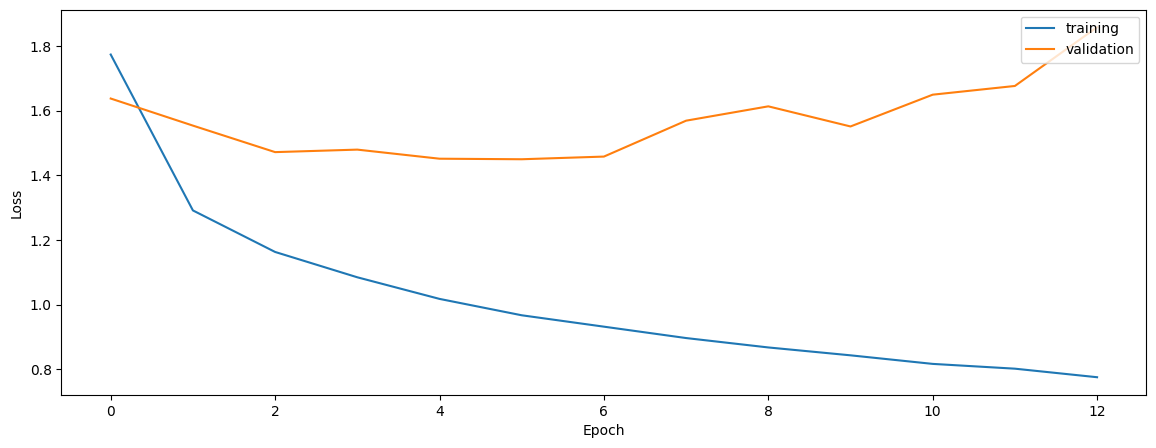

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6384221453477124
0.4722833242665784
0.5513281140780092


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5830157341955983
0.5020749695520772
0.5495397942609638


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5667424167572375
0.48568220101066817
0.539536594336153


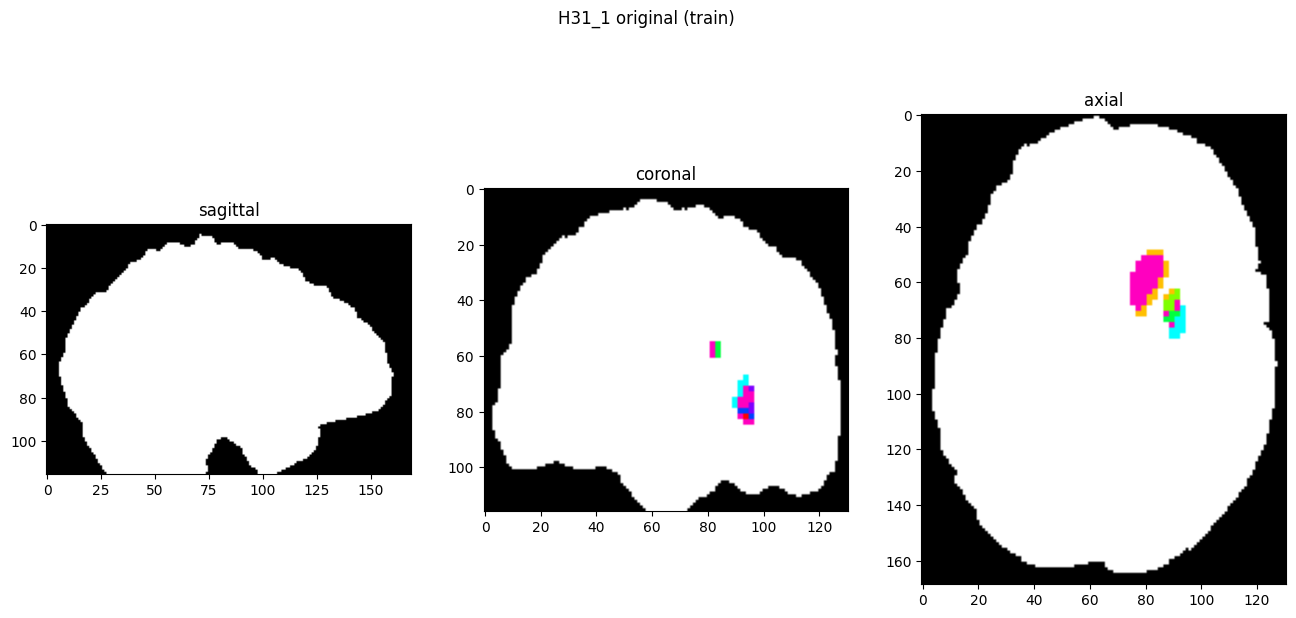

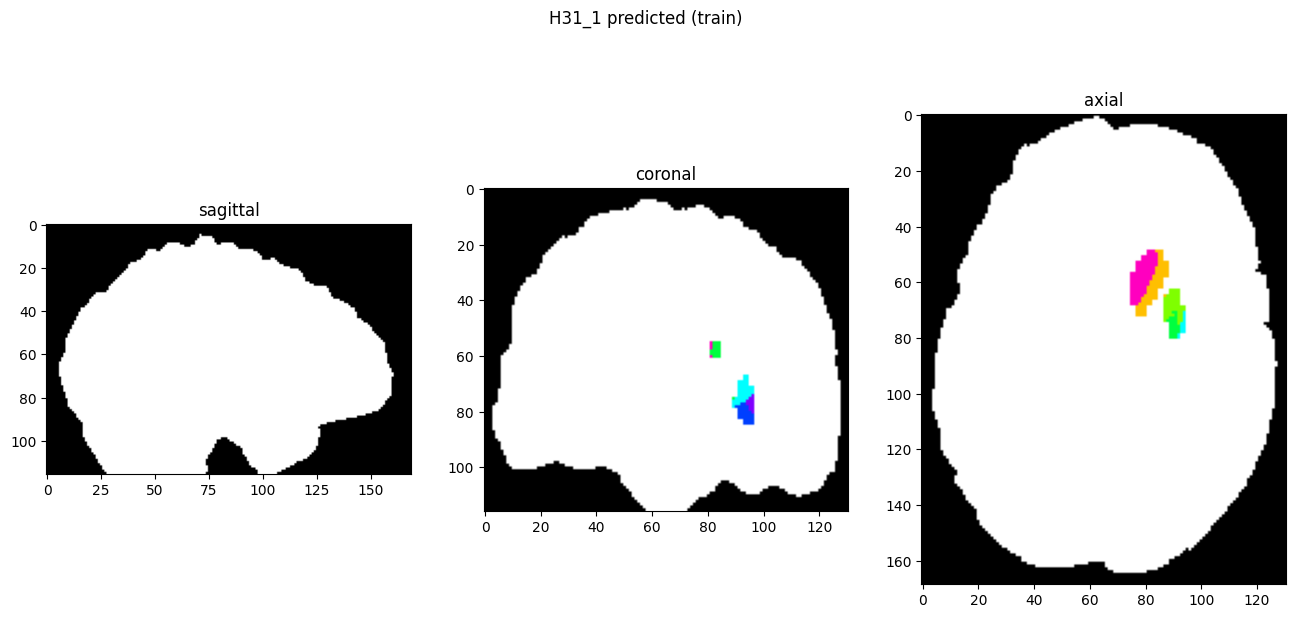

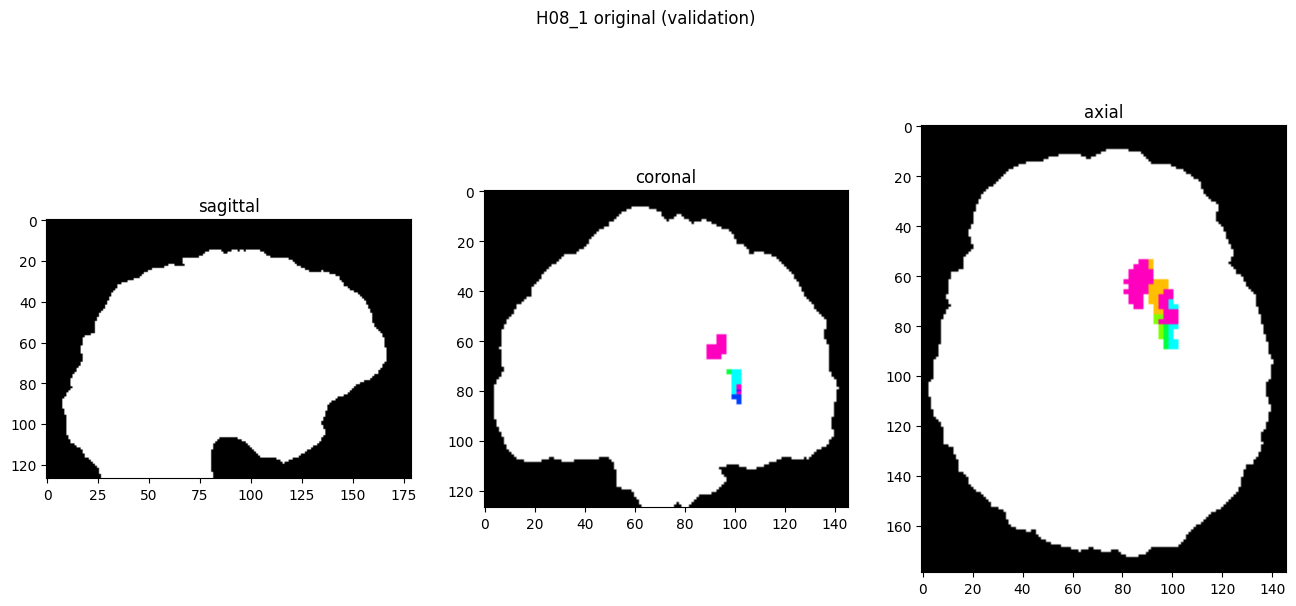

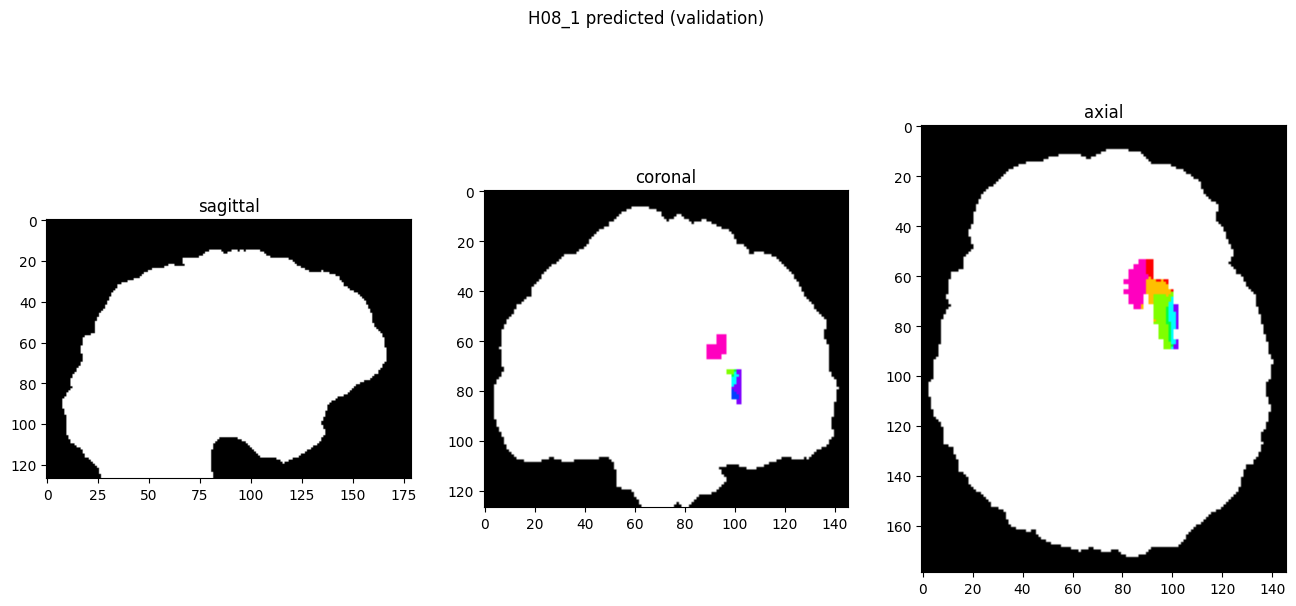

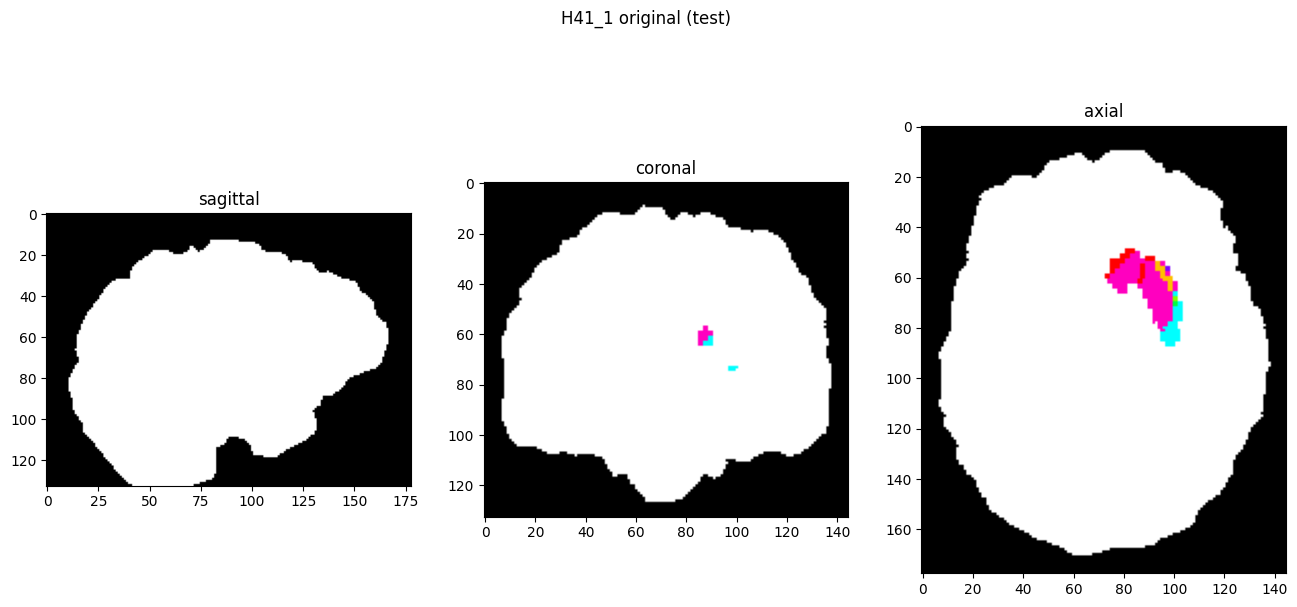

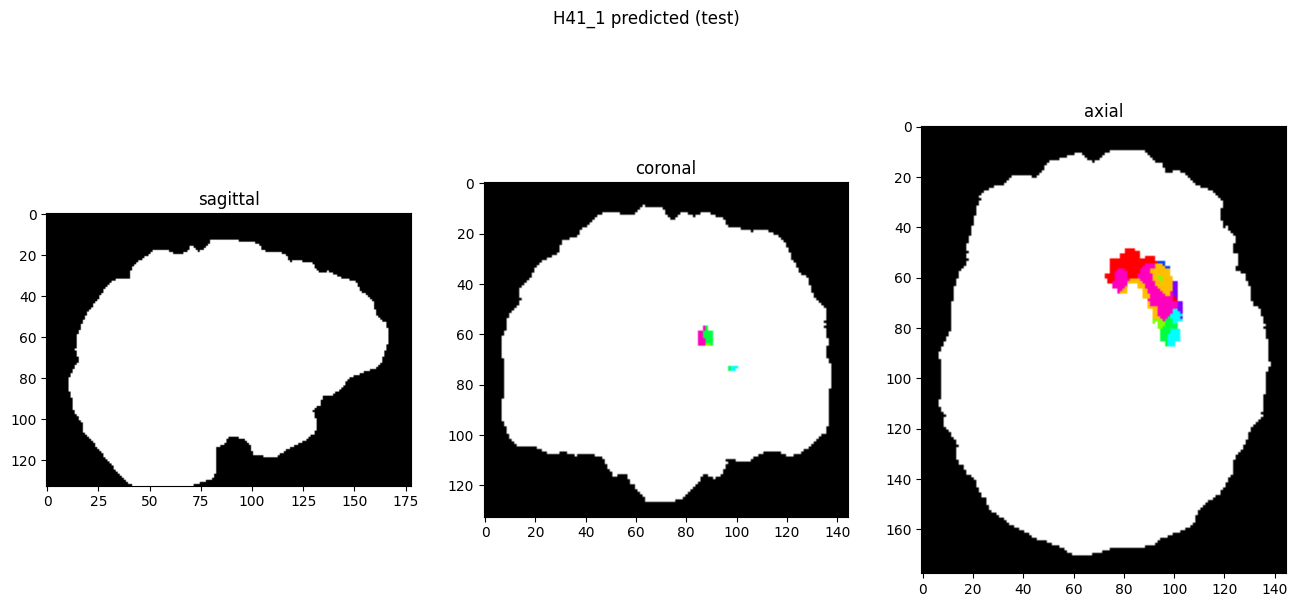

In [10]:
showResults(model, gen, threshold=0)